In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter,ImageEnhance
import PIL
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


np.random.seed(100)
LEVEL = 'level_4b'

In [2]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [3]:
def remove_grey(value):
    if value > 20:
        return 255
    else:
        return value

In [4]:
def read_all_test(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)                
        image_index = key_prefix + file_name[:-4]
        im = Image.open(file_path)
        im = im.convert("L")
        im = im.point(remove_grey)
        im = im.filter(ImageFilter.ModeFilter(3))
        images[image_index] = np.array(im.copy()).flatten()       
        im.close()
    return images

In [5]:
def read_all_train(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)                
        image_index = key_prefix + file_name[:-4]
        image_blurr_index = key_prefix + 'blurr' + file_name[:-4]
        image_rotate_index = key_prefix + 'rotate' + file_name[:-4]
        im = Image.open(file_path)
        im = im.convert("L")
        im = im.point(remove_grey)
        im = im.filter(ImageFilter.ModeFilter(3))
        images[image_index] = np.array(im.copy()).flatten()
        im_b = im.filter(ImageFilter.GaussianBlur(1))
        images[image_blurr_index] = np.array(im_b.copy()).flatten()
        im_r = im.rotate(180)
        images[image_rotate_index] = np.array(im_r.copy()).flatten()        
        im.close()
        im_b.close()
        im_r.close()
    return images

In [6]:
languages = ['ta', 'hi', 'en']

images_train = read_all_train(r"../input/level_4b_train/"+LEVEL+"/"+"background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all_train(r"../input/level_4b_train/"+LEVEL+"/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all_test(r'../input/level_4b_test/kaggle_'+LEVEL, key_prefix='') # change the path
print(len(images_test))

Reading:



Reading:



Reading:



Reading:



27000
Reading:



3000


In [7]:
X_bgr = []
X_text = []
for key, value in images_train.items():
    if key[:4]=="bgr_":
        X_bgr.append(value)
    else:
        X_text.append(value)

In [8]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)
print (type(X_train),type(Y_train),type(X_test))

(27000, 4096) (27000,)
(3000, 4096)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
X_train_train , X_train_validate, Y_train_train ,Y_train_validate = train_test_split(X_train ,Y_train,test_size = 0.3, stratify = Y_train , random_state = 0)

In [10]:
scaler = StandardScaler()
X_scaled_train_ = scaler.fit_transform(X_train)
X_scaled_train_train  = scaler.transform(X_train_train)
X_scaled_train_validate  = scaler.transform(X_train_validate)
X_scaled_test = scaler.transform(X_test)
X_scaled_bgr = scaler.transform(X_bgr)
X_scaled_text = scaler.transform(X_text)

In [11]:
#sn_mse = SigmoidNeuron()
#sn_mse.fit(X_scaled_train_train, Y_train_train, epochs=1000, learning_rate=0.030, loss_fn="mse", display_loss=True)

In [12]:
sn_ce = SigmoidNeuron()

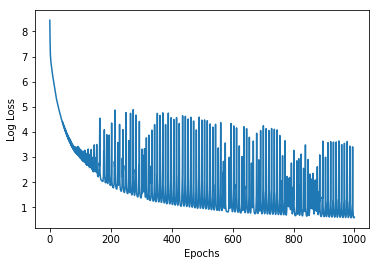

In [13]:
sn_ce.fit(X_scaled_train_train, Y_train_train, epochs=1000, learning_rate=0.00003, initialise= True ,loss_fn="ce", display_loss=True)

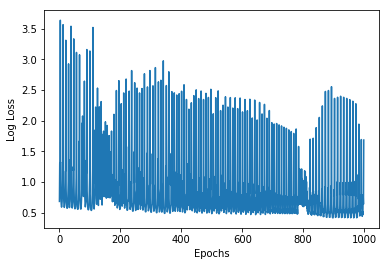

In [14]:
sn_ce.fit(X_scaled_train_train, Y_train_train, epochs=1000, learning_rate=0.00003, initialise= False ,loss_fn="ce", display_loss=True)

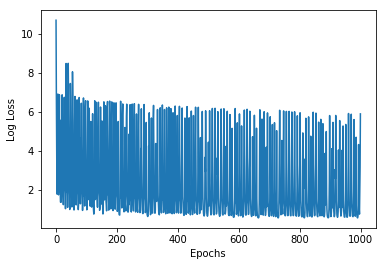

In [15]:
sn_ce.fit(X_scaled_train_train, Y_train_train, epochs=1000, learning_rate=0.00008, initialise= False ,loss_fn="ce", display_loss=True)

In [16]:
X_train_train_2 , X_train_validate_2, Y_train_train_2 ,Y_train_validate_2 = train_test_split(X_train ,Y_train,test_size = 0.3, stratify = Y_train , random_state = 5)

In [17]:
X_scaled_train_train_2  = scaler.transform(X_train_train_2)
X_scaled_train_validate_2  = scaler.transform(X_train_validate_2)

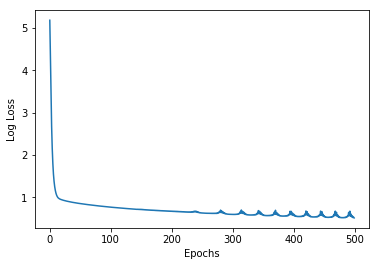

In [18]:
sn_ce.fit(X_scaled_train_train_2, Y_train_train_2, epochs=500, learning_rate=0.00003, initialise= False ,loss_fn="ce", display_loss=True)

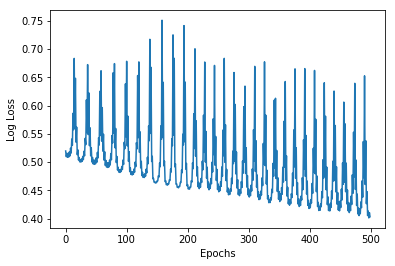

In [19]:
sn_ce.fit(X_scaled_train_train_2, Y_train_train_2, epochs=500, learning_rate=0.00003, initialise= False ,loss_fn="ce", display_loss=True)

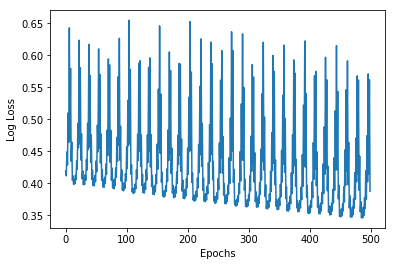

In [20]:
sn_ce.fit(X_scaled_train_train_2, Y_train_train_2, epochs=500, learning_rate=0.00003, initialise= False ,loss_fn="ce", display_loss=True)

In [21]:
#print(X_scaled_train_.shape, Y_train.shape)

In [22]:
def print_accuracy_2(sn):
  Y_pred_train_train = sn.predict(X_scaled_train_validate_2)
  Y_pred_binarised_train_train = (Y_pred_train_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train_train, Y_train_validate_2)
  print("Validate2 accuracy : ", accuracy_train)
  print("-"*50)

In [23]:
def print_accuracy(sn):
  Y_pred_train_train = sn.predict(X_scaled_train_train)
  Y_pred_binarised_train_train = (Y_pred_train_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train_train, Y_train_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)

In [24]:
def print_accuracy_validate(sn):
  Y_pred_train_validate = sn.predict(X_scaled_train_validate)
  Y_pred_binarised_train_validate = (Y_pred_train_validate >= 0.3).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train_validate, Y_train_validate)
  print("Validate Accuracy : ", accuracy_train)
  print("-"*50)

In [25]:
def print_accuracy_complete(sn):
  Y_pred_train = sn.predict(X_scaled_train_)
  Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Complete Accuracy : ", accuracy_train)
  print("-"*50)

In [26]:
#y_bgr = sn_ce.predict(X_scaled_bgr)
#df = pd.DataFrame(y_bgr)
#df.describe()

In [27]:
print_accuracy(sn_ce)
print_accuracy_validate(sn_ce)
print_accuracy_complete(sn_ce)
print_accuracy_2(sn_ce)

Train Accuracy :  0.9212698412698412
--------------------------------------------------
Validate Accuracy :  0.8948148148148148
--------------------------------------------------
Complete Accuracy :  0.9164814814814815
--------------------------------------------------
Validate2 accuracy :  0.8959259259259259
--------------------------------------------------


## Sample Submission

In [28]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)